# CIV1498 - Introduction to Data Science
## Project - Toronto Bike Share
## PART II: Eploratory Data Analysis
### By: Gneiss Data (Greig Knox and Yoko Yanagimura)

In this section, we will work with the cleaned and merged bike station and weather data derived from Part I. We will explore the dataset to extract insights that will help answer some of the questions posed by the City of Toronto. 

The list below shows the questions that were posed by the City of Toronto. We aim to answer the following questions through the analyses presented in this notebook:

1. Is there an increasing trend of usage from 2017 to 2020 and is the trend the same for both Casual and Annual Member riders?

2. Is there a difference in usage behaviour between Casual and Annual Member riders?

3. Which neighbourhoods have seen the largest number of rides depart from bike stations located within their boundaries?

4. Which neighbourhoods have seen the largest number of rides end at bike stations located within their boundaries?

5. How popular is FREE RIDE WEDNESDAYS?

6. How does the weather change the way people use the bike share system?

7. What weather features are most influential (temperature, humidity, precipitation, etc.)?

8. When are people using the bike share system? How does usage vary across the year, the week, and the day?

9. How did usage change in 2020 due to the pandemic and government-mandated lockdowns?

10. How do statutory holidays impact demand?

We have also conducted a series of analyses to provide some of our own insights into the dataset. We have attempted to answer the following questions through our analyses:

1. Does bike-share usage vary depending on proximity to TTC subway and streetcar stations?

2. Are there seasonal or geographic trends in trip duration?

3. If everyone is travelling along bike paths, which bike paths are the most congested and at what times of the day?

4. Are people using the bike-share system to access TTC stations?

5. How are people using the system, is it to commute to work or to explore the city?

## 0. Setup Notebook and Import Data

In [1]:
# Import 3rd party libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pytz
import chardet
import string
import datetime
import geopandas as gpd
import folium
import matplotlib.ticker as ticker
from folium import Choropleth
from folium import Marker

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Centre all the charts displayed in this notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")

We will import the cleaned bike trip dataset that will be used for analysis. 

In [2]:
#Import cleaned bike trip data
df_trips_data=pd.read_csv('df_merged_data.csv')
df_trips_data.set_index(keys='trip_id', drop=True, inplace=True)
df_trips_data.head()

subscription_id  trip_duration  start_station_id  \
trip_id                                                     
712441               NaN            274            7006.0   
712442               NaN            538            7046.0   
712443               NaN            992            7048.0   
712444               NaN           1005            7177.0   
712445               NaN            645            7203.0   

                        start_time                         start_station_name  \
trip_id                                                                         
712441   2017-01-01 00:03:00-05:00            Bay St / College St (East Side)   
712442   2017-01-01 00:03:00-05:00                 Niagara St / Richmond St W   
712443   2017-01-01 00:05:00-05:00  Front St / Yonge St (Hockey Hall of Fame)   
712444   2017-01-01 00:09:00-05:00            East Liberty St / Pirandello St   
712445   2017-01-01 00:14:00-05:00                Bathurst St / Queens Quay W   

         end_station_id                   end_time  \
trip_id                                              
712441           7021.0  2017-01-01 00:08:00-05:00   
712442           7147.0  2017-01-01 00:12:00-05:00   
712443           7089.0  2017-01-01 00:22:00-05:00   
712444           7202.0  2017-01-01 00:26:00-05:00   
712445           7010.0  2017-01-01 00:25:00-05:00   

                         end_station_name  bike_id      user_type  ... temp_c  \
trip_id                                                            ...          
712441                 Bay St / Albert St      NaN  annual member  ...    1.5   
712442             King St W / Fraser Ave      NaN  annual member  ...    1.5   
712443               Church St  / Wood St      NaN  annual member  ...    1.5   
712444   Queen St W / York St (City Hall)      NaN  annual member  ...    1.5   
712445            King St W / Spadina Ave      NaN  annual member  ...    1.5   

        dew_point_temp_c  rel_hum_  wind_dir_10s_deg  wind_spd_kmh  \
trip_id                                                              
712441              -3.6      69.0              26.0          39.0   
712442              -3.6      69.0              26.0          39.0   
712443              -3.6      69.0              26.0          39.0   
712444              -3.6      69.0              26.0          39.0   
712445              -3.6      69.0              26.0          39.0   

         visibility_km stn_press_kpa  hmdx  wind_chill    weather  
trip_id                                                            
712441            16.1         99.81   NaN         NaN  clear_day  
712442            16.1         99.81   NaN         NaN  clear_day  
712443            16.1         99.81   NaN         NaN  clear_day  
712444            16.1         99.81   NaN         NaN  clear_day  
712445            16.1         99.81   NaN         NaN  clear_day  

[5 rows x 31 columns]

We will keep the backup of the trip data saved in a different variable, in case we need to reset the applied manipulations. 

In [3]:
#backup of the dataframe
df_trips_data2=df_trips_data.copy()

In [4]:
#df_trip_data=df_trips_data2

# 1. Understanding the Dataset

Before diving into the analysis, it is important to understand and define the following properties about our dataset. 
1. Structure - what is the format of our data file?

2.  Granularity - how fine or coarse is each row and column?

3. Scope - how complete is our data set?

Some of these questions were already explored in the Part I (Data Cleaning and Wrangling), but we would like to reiterate the subject in more details in this section. 

### Structure

The structure of the datafile can be examined by looking at the "shape". We can see that there are 7924851 rows and 32 columns. 

In [5]:
df_trips_data.shape

(8007423, 31)

What are the fields (e.g. columns) in each record? What is the type of each column? We can use .columns to examine this. We can see that there data about the trip and the associated information about the weather when the trip was taken. We joined the bike trip data and the weather dataframe together in Part I. 

In [6]:
df_trips_data.columns

Index(['subscription_id', 'trip_duration', 'start_station_id', 'start_time',
       'start_station_name', 'end_station_id', 'end_time', 'end_station_name',
       'bike_id', 'user_type', 'start_station_name_npl',
       'end_station_name_npl', 'start_station_lat', 'start_station_lon',
       'end_station_lat', 'end_station_lon', 'merge_time', 'year', 'month',
       'day', 'time', 'temp_c', 'dew_point_temp_c', 'rel_hum_',
       'wind_dir_10s_deg', 'wind_spd_kmh', 'visibility_km', 'stn_press_kpa',
       'hmdx', 'wind_chill', 'weather'],
      dtype='object')

To summarize the data cleaning conducted in Part I, the records removed from the dataset include:

- Trip records outside the January 1, 2017 and October 31, 2020 range 
- Trip records with extreme and unrealistic trip durations based on the inter-quartile range
- Trip records with unknown start or end locations (i.e. missing station name and station id)
- Trip records with start or end stations not included in the provided bike station dataset (i.e. unknown start and end coordinates)



In [7]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

count  percent_nulldata
subscription_id         3199754              40.0
trip_duration                 0               0.0
start_station_id              0               0.0
start_time                    0               0.0
start_station_name            0               0.0
end_station_id                0               0.0
end_time                      0               0.0
end_station_name              0               0.0
bike_id                 3199754              40.0
user_type                     0               0.0
start_station_name_npl        0               0.0
end_station_name_npl          0               0.0
start_station_lat             0               0.0
start_station_lon             0               0.0
end_station_lat               0               0.0
end_station_lon               0               0.0
merge_time                    0               0.0
year                          0               0.0
month                         0               0.0
day                           0               0.0
time                          0               0.0
temp_c                    48475               0.6
dew_point_temp_c          59007               0.7
rel_hum_                  57615               0.7
wind_dir_10s_deg          14177               0.2
wind_spd_kmh              14177               0.2
visibility_km                 0               0.0
stn_press_kpa             50633               0.6
hmdx                    5151443              64.3
wind_chill              7578399              94.6
weather                       0               0.0

We use '.info' to see the datatype of each column contained the data_merged dataframe. 

We can see that the <code>'start_time',</code> and <code>'end_time'</code> need to be converted into datetime objects again localized to the EST timezone.

We can see that the <code>'start_station_id',</code> and <code>'end_station_id'</code> can be converted into integers. 



In [8]:
df_trips_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8007423 entries, 712441 to 10293875
Data columns (total 31 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   subscription_id         float64
 1   trip_duration           int64  
 2   start_station_id        float64
 3   start_time              object 
 4   start_station_name      object 
 5   end_station_id          float64
 6   end_time                object 
 7   end_station_name        object 
 8   bike_id                 float64
 9   user_type               object 
 10  start_station_name_npl  object 
 11  end_station_name_npl    object 
 12  start_station_lat       float64
 13  start_station_lon       float64
 14  end_station_lat         float64
 15  end_station_lon         float64
 16  merge_time              object 
 17  year                    int64  
 18  month                   int64  
 19  day                     int64  
 20  time                    object 
 21  temp_c                  f

In [9]:
#Convert start and end time into tz-aware datetime object
df_trips_data['start_time']=pd.to_datetime(df_trips_data['start_time'],utc=True)
df_trips_data['end_time']=pd.to_datetime(df_trips_data['end_time'],utc=True)
df_trips_data['merge_time']=pd.to_datetime(df_trips_data['merge_time'],utc=True)
df_trips_data['start_time']=df_trips_data['start_time'].dt.tz_convert(tz='US/Eastern')
df_trips_data['end_time']=df_trips_data['end_time'].dt.tz_convert(tz='US/Eastern')
df_trips_data['merge_time']=df_trips_data['merge_time'].dt.tz_convert(tz='US/Eastern')

print(df_trips_data['start_time'].dtype)
print(df_trips_data['end_time'].dtype)
print(df_trips_data['merge_time'].dtype)
df_trips_data.head()

datetime64[ns, US/Eastern]
datetime64[ns, US/Eastern]
datetime64[ns, US/Eastern]


subscription_id  trip_duration  start_station_id  \
trip_id                                                     
712441               NaN            274            7006.0   
712442               NaN            538            7046.0   
712443               NaN            992            7048.0   
712444               NaN           1005            7177.0   
712445               NaN            645            7203.0   

                       start_time                         start_station_name  \
trip_id                                                                        
712441  2017-01-01 00:03:00-05:00            Bay St / College St (East Side)   
712442  2017-01-01 00:03:00-05:00                 Niagara St / Richmond St W   
712443  2017-01-01 00:05:00-05:00  Front St / Yonge St (Hockey Hall of Fame)   
712444  2017-01-01 00:09:00-05:00            East Liberty St / Pirandello St   
712445  2017-01-01 00:14:00-05:00                Bathurst St / Queens Quay W   

         end_station_id                  end_time  \
trip_id                                             
712441           7021.0 2017-01-01 00:08:00-05:00   
712442           7147.0 2017-01-01 00:12:00-05:00   
712443           7089.0 2017-01-01 00:22:00-05:00   
712444           7202.0 2017-01-01 00:26:00-05:00   
712445           7010.0 2017-01-01 00:25:00-05:00   

                         end_station_name  bike_id      user_type  ... temp_c  \
trip_id                                                            ...          
712441                 Bay St / Albert St      NaN  annual member  ...    1.5   
712442             King St W / Fraser Ave      NaN  annual member  ...    1.5   
712443               Church St  / Wood St      NaN  annual member  ...    1.5   
712444   Queen St W / York St (City Hall)      NaN  annual member  ...    1.5   
712445            King St W / Spadina Ave      NaN  annual member  ...    1.5   

        dew_point_temp_c  rel_hum_  wind_dir_10s_deg  wind_spd_kmh  \
trip_id                                                              
712441              -3.6      69.0              26.0          39.0   
712442              -3.6      69.0              26.0          39.0   
712443              -3.6      69.0              26.0          39.0   
712444              -3.6      69.0              26.0          39.0   
712445              -3.6      69.0              26.0          39.0   

         visibility_km stn_press_kpa  hmdx  wind_chill    weather  
trip_id                                                            
712441            16.1         99.81   NaN         NaN  clear_day  
712442            16.1         99.81   NaN         NaN  clear_day  
712443            16.1         99.81   NaN         NaN  clear_day  
712444            16.1         99.81   NaN         NaN  clear_day  
712445            16.1         99.81   NaN         NaN  clear_day  

[5 rows x 31 columns]

In [10]:
#convert the station ids into integers
df_trips_data['end_station_id']=df_trips_data['end_station_id'].astype(int)
df_trips_data['start_station_id']=df_trips_data['start_station_id'].astype(int)

# 1. Is there an increasing trend of usage from 2017 to 2020 and is the trend the same for both Casual and Annual Member riders?


We will look at the trend in bike share usage by looking at the changes in daily trip counts from 2017 to 2020. We will use the <code> .groupby.agg() </code> function to determine the daily trip count by date. We also broke the trip dataset down by the membership type to determine if the observed trend is the same for both casual and annual member riders. 

In [11]:
#Use the start_station_id as proxy for estimating total number of trips on each date because we know every trip has a start and end station id

# Determine the daily trip count for every date by using the groupby function, this is for all membership type
df_usage_perd = df_trips_data.groupby(pd.Grouper(key="start_time",
                                                 freq='D')).agg(trip_count=('start_station_id',"count"))
df_usage_perd['member']='total'

#Filter trip data by membership type
df_trips_data_casual=df_trips_data[df_trips_data['user_type']=='casual member']
df_trips_data_annual=df_trips_data[df_trips_data['user_type']=='annual member']

#Daily trip count for casual membership only 
df_usage_perd_casual = df_trips_data_casual.groupby(pd.Grouper(key="start_time",
                                                               freq='D')).agg(trip_count=('start_station_id',"count"))
df_usage_perd_casual['member']='casual'

#Daily trip count for annual membership only 
df_usage_perd_annual = df_trips_data_annual.groupby(pd.Grouper(key="start_time",
                                                               freq='D')).agg(trip_count=('start_station_id',"count"))
df_usage_perd_annual['member']='annual'

#Combine the daily trip count dataframe for total, casual and annual member
df_usage_perd_bymem=pd.concat([df_usage_perd, df_usage_perd_casual,df_usage_perd_annual])

#Create new column field extracting year, day of year, day, month,weekday from Datetime index
df_usage_perd_bymem['year']=df_usage_perd_bymem.index.year
df_usage_perd_bymem['dayofyear']=df_usage_perd_bymem.index.dayofyear
df_usage_perd_bymem['day']=df_usage_perd_bymem.index.day
df_usage_perd_bymem['month']=df_usage_perd_bymem.index.month
df_usage_perd_bymem['dayofweek'] = df_usage_perd_bymem.index.dayofweek
df_usage_perd_bymem['isweek_day'] = df_usage_perd_bymem.index.weekday <6
df_usage_perd_bymem.loc[df_usage_perd_bymem['isweek_day'], 'isweek_day'] = 'weekday'
df_usage_perd_bymem.loc[df_usage_perd_bymem['isweek_day'] ==False,'isweek_day'] = 'weekend'


print(df_usage_perd_bymem['member'].unique())
df_usage_perd_bymem.head()

['total' 'casual' 'annual']


trip_count member  year  dayofyear  day  month  \
start_time                                                                  
2017-01-01 00:00:00-05:00         482  total  2017          1    1      1   
2017-01-02 00:00:00-05:00         826  total  2017          2    2      1   
2017-01-03 00:00:00-05:00         871  total  2017          3    3      1   
2017-01-04 00:00:00-05:00        1395  total  2017          4    4      1   
2017-01-05 00:00:00-05:00        1210  total  2017          5    5      1   

                           dayofweek isweek_day  
start_time                                       
2017-01-01 00:00:00-05:00          6    weekend  
2017-01-02 00:00:00-05:00          0    weekday  
2017-01-03 00:00:00-05:00          1    weekday  
2017-01-04 00:00:00-05:00          2    weekday  
2017-01-05 00:00:00-05:00          3    weekday

Use use the lineplot to show the daily trip count between 2017 and 2018 for all member types. We can definitely see a increasing trend here, but the trend is confounded by day-to-day fluctuations in the daily trip count. We determined that the usage trend will be easier to observe if we look at the average daily trip count by month. 

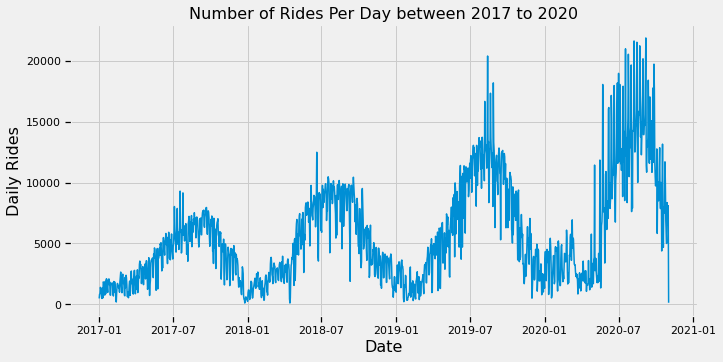

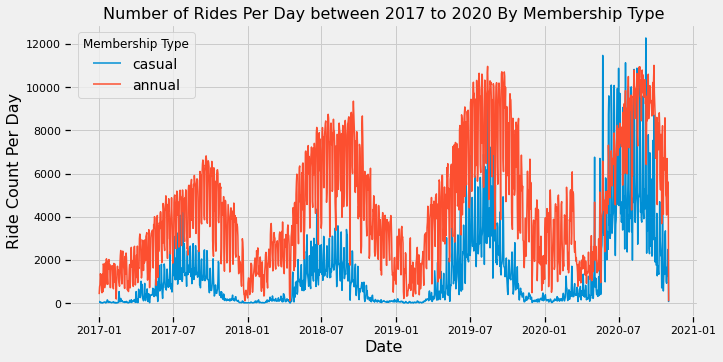

In [12]:
#lineplot for all member types, daily trip count by date
plt.figure(figsize=(10,5))
usage=sns.lineplot(x=df_usage_perd.index,y=df_usage_perd['trip_count'])
usage.axes.set_title("Number of Rides Per Day between 2017 to 2020",
                      fontsize=16)
usage.set_ylabel("Daily Rides",
                  fontsize=16)
usage.set_xlabel("Date",
                  fontsize=16)
plt.show()

#lineplot for causal and annual membership, daily trip count by date
plt.figure(figsize=(10,5))
usage=sns.lineplot(x=df_usage_perd_bymem[~(df_usage_perd_bymem['member']=='total')].index,
                   y=df_usage_perd_bymem[~(df_usage_perd_bymem['member']=='total')]['trip_count'], 
                   hue=df_usage_perd_bymem[~(df_usage_perd_bymem['member']=='total')]['member'])
usage.axes.set_title("Number of Rides Per Day between 2017 to 2020 By Membership Type",
                      fontsize=16)
usage.set_ylabel("Ride Count Per Day",
                  fontsize=16)
usage.set_xlabel("Date",
                  fontsize=16)
usage.legend(title="Membership Type",
                    fontsize=14)
plt.show()

Comparisons of Average Daily Rides by Month shows that there is increasing trend of usage from 2017 to 2020, particularly between May and October. The trend is not as obvious during the colder months between November and April. 

Keep in mind that we did not have any bike trip data for November and December 2020. For this reason, there comparison is not available for November and December for Year 2020. 

Based on the below graphs, we can see that there is a consistent increase in the useage for all member types from 2017 to 2020. When we breakdown the daily ride count by membership type, we can see that the biggest jumps in useage was between 2018-2019 and 2019-2020 for casual members. For the annual members, the usage jumps were more significant between 2017-2018 and 2018-2019 to a lesser degree. 

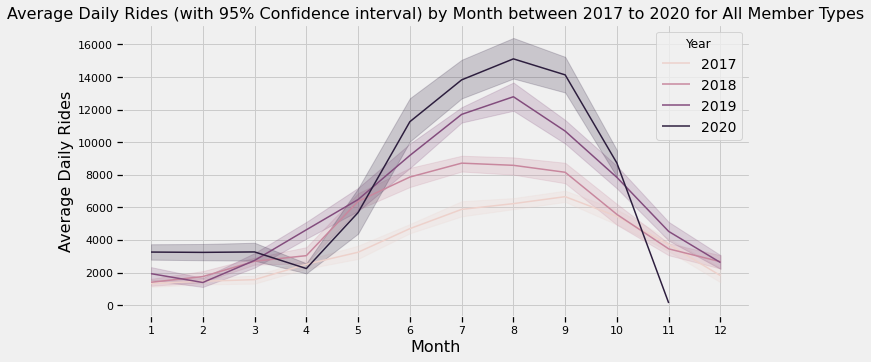

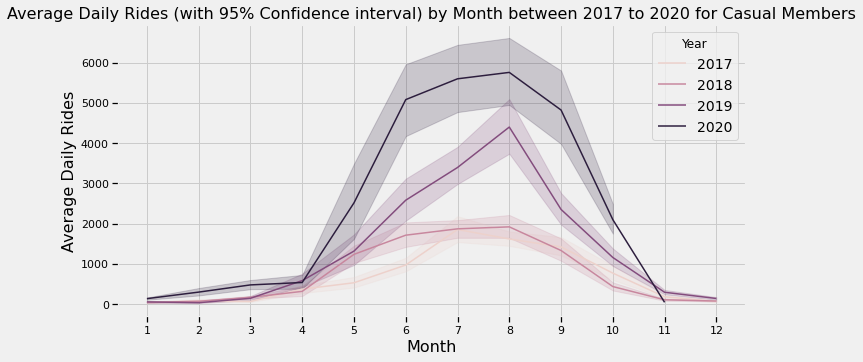

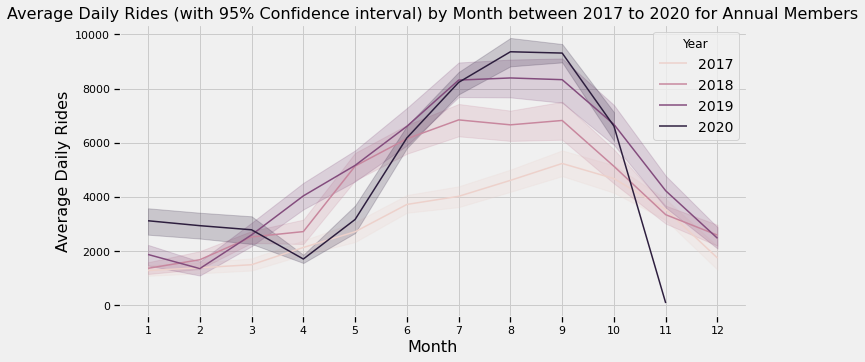

In [13]:
plt.figure(figsize=(10,5))
ax=sns.lineplot(data=df_usage_perd_bymem[df_usage_perd_bymem['member']=='total'], x="month", y="trip_count", hue="year", err_style = 'band', ci=95)
ax.axes.set_title("Average Daily Rides (with 95% Confidence interval) by Month between 2017 to 2020 for All Member Types",
                      fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
ax.set_xlabel("Month",
                  fontsize=16)
ax.legend(title="Year",
                    fontsize=14)
plt.show()

# Same plot but only for casual members
plt.figure(figsize=(10,5))
ax2=sns.lineplot(data=df_usage_perd_bymem[df_usage_perd_bymem['member']=='casual'], x="month", y="trip_count", hue="year", err_style = 'band', ci=95)
ax2.axes.set_title("Average Daily Rides (with 95% Confidence interval) by Month between 2017 to 2020 for Casual Members",
                      fontsize=16)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.set_ylabel("Average Daily Rides",
                  fontsize=16)
ax2.set_xlabel("Month",
                  fontsize=16)
ax2.legend(title="Year",
                    fontsize=14)
plt.show()

# Same plot but only for annual members
plt.figure(figsize=(10,5))
ax3=sns.lineplot(data=df_usage_perd_bymem[df_usage_perd_bymem['member']=='annual'], x="month", y="trip_count", hue="year", err_style = 'band', ci=95)
ax3.axes.set_title("Average Daily Rides (with 95% Confidence interval) by Month between 2017 to 2020 for Annual Members",
                      fontsize=16)
ax3.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax3.set_ylabel("Average Daily Rides",
                  fontsize=16)
ax3.set_xlabel("Month",
                  fontsize=16)
ax3.legend(title="Year",
                    fontsize=14)
plt.show()

The same trend discussed in the above section can be depicted using bar plots looking at the average daily trip count by year.  

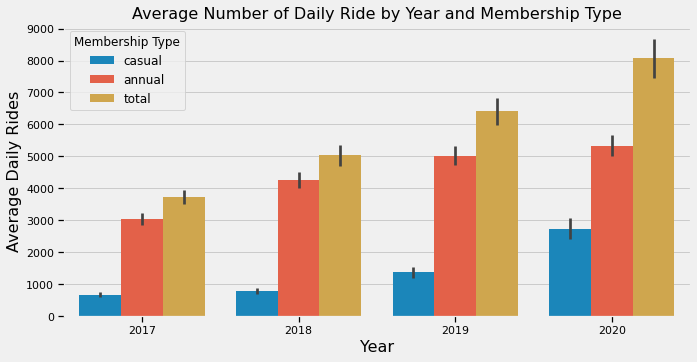

In [14]:
#Plot showing the average daily rides by year
plt.figure(figsize=(10,5))
ax = sns.barplot(x=df_usage_perd_bymem.year, y=df_usage_perd_bymem.trip_count, 
                 hue=df_usage_perd_bymem.member, hue_order=['casual','annual','total'])
ax.axes.set_title("Average Number of Daily Ride by Year and Membership Type",
                      fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.legend(title="Membership Type",
                    fontsize=12)
plt.show()

# 2. Is there a difference in usage behaviour between Casual and Annual Member riders?

As part of this question, we explored the following questions:
1) Is there a change in usage whether it is a weekday or weekend for casual and annual members?

2) Is there a change in usage by time of day for casual and annual members?

We believe that the annual members have obtained their membership because they use the bike share on a regular basis. For this reason, they would be taking the bike trips mainly for commuting in additional some recreational trip they take after work hours or on the weekends. On the other hand, casual members do not rely on the bikes to get from Point A to Point B on a regular basis, so bike rides are not used for commuting like the annual members. Because the intentions of the annual and casual members are different, we anticipated that the usage will differ by membership type. 


## Daily Usage by Weekday or Weekend

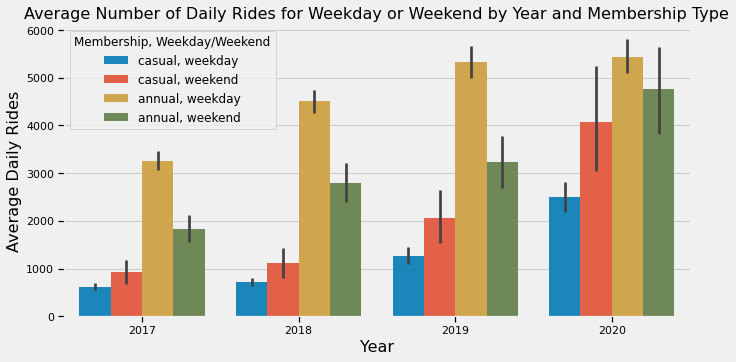

In [15]:
#create a new column that will be used for category 
df_usage_perd_bymem['member_week_day'] = df_usage_perd_bymem['member'] +', '+df_usage_perd_bymem['isweek_day']

plt.figure(figsize=(10,5))
ax = sns.barplot(x=df_usage_perd_bymem[~(df_usage_perd_bymem['member']=='total')].year, 
                 y=df_usage_perd_bymem[~(df_usage_perd_bymem['member']=='total')].trip_count, 
                 hue=df_usage_perd_bymem[~(df_usage_perd_bymem['member']=='total')].member_week_day,
                 hue_order=['casual, weekday','casual, weekend','annual, weekday','annual, weekend'])
ax.axes.set_title("Average Number of Daily Rides for Weekday or Weekend by Year and Membership Type",
                      fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
ax.legend(title="Membership, Weekday/Weekend",
                    fontsize=12)
plt.show()


As the graph above shows, there are typically more annual riders during the week than on the weekends. The inverse is true for the causal riders. They tend to take more rides over the weekend.

It is interesting to note that the gap between the weekday and weekend usage decreases in 2020 for the annual riders. We think this is partially due to the impact of COVID-19, which caused a lot of people to work from home. This eliminated the need for people to commute on a regular basis. For this reason, the weekday usage for annual members did not go up significantly compared to the previous year, while the usage over the weekend continued to increase. We also see in 2020 that the weekend usage went up significantly for casual memebers. We speculate that bike share was considered by many people to be a safe recreational activity in the midst of the COVID lockdowns experienced in Toronto. 

## Hourly Usage Between Casual and Annual Members

The graph below depicting the hourly ride counts by membership type. For annual members, there are distinct peaks during rush hour indicating the high demand for bikes during typical commuting times (8-11AM and 5-8PM). For casual rider, the demands tend to start increasing in the afterneon and peaks in the evening between 6 - 7PM.

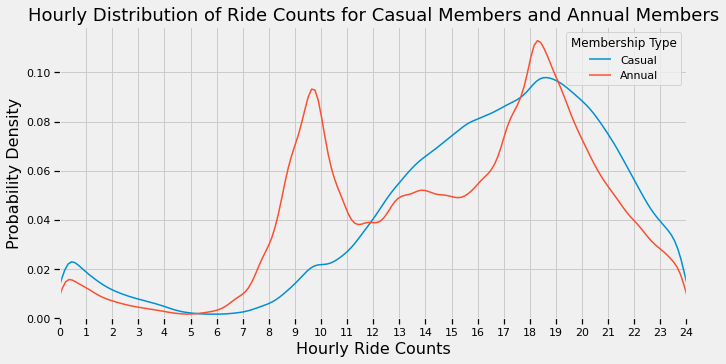

In [61]:
df_trips_data['hour']=[(x.hour+x.minute/60+x.second/60**2) for x in df_trips_data['start_time']]

fig1 = plt.figure(figsize=(10,5))
ax2 = fig1.subplots()
ax2.set_xlim(0,24)

#map data
sns.distplot(df_trips_data[df_trips_data['user_type'] == 'casual member']['hour'], label = "Casual",ax = ax2, hist = False)
sns.distplot(df_trips_data[df_trips_data['user_type'] == 'annual member']['hour'], label = "Annual",ax = ax2, hist = False)

#formate titles
ax2.set_title("Hourly Distribution of Ride Counts for Casual Members and Annual Members",fontsize = 18)
ax2.set_xlabel("Hourly Ride Counts", fontsize = 16)
ax2.set_ylabel("Probability Density", fontsize = 16)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend(title='Membership Type')
plt.show()

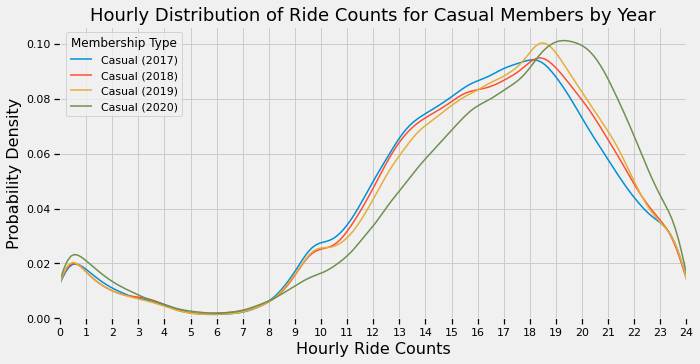

In [17]:
fig1 = plt.figure(figsize=(10,5))
ax2 = fig1.subplots()
ax2.set_xlim(0,24)

#map data
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'casual member')& (df_trips_data['start_time'].dt.year == 2017)]['hour'], label = "Casual (2017)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'casual member')& (df_trips_data['start_time'].dt.year == 2018)]['hour'], label = "Casual (2018)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'casual member')& (df_trips_data['start_time'].dt.year == 2019)]['hour'], label = "Casual (2019)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'casual member')& (df_trips_data['start_time'].dt.year == 2020)]['hour'], label = "Casual (2020)",ax = ax2, hist = False)
             
#formate titles
ax2.set_title("Hourly Distribution of Ride Counts for Casual Members by Year",fontsize = 18)
ax2.set_xlabel("Hourly Ride Counts", fontsize = 16)
ax2.set_ylabel("Probability Density", fontsize = 16)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend(title='Membership Type')
plt.show()

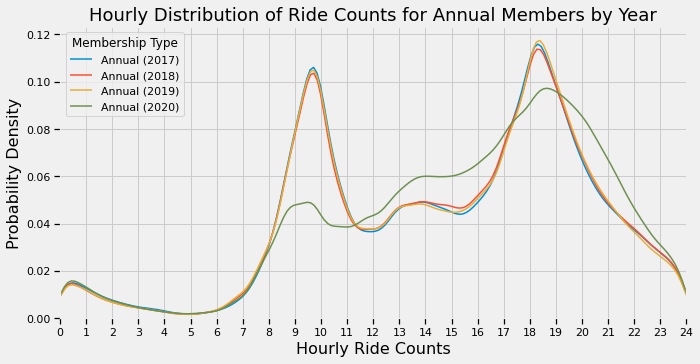

In [18]:
fig1 = plt.figure(figsize=(10,5))
ax2 = fig1.subplots()
ax2.set_xlim(0,24)

#map data
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'annual member')& (df_trips_data['start_time'].dt.year == 2017)]['hour'], label = "Annual (2017)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'annual member')& (df_trips_data['start_time'].dt.year == 2018)]['hour'], label = "Annual (2018)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'annual member')& (df_trips_data['start_time'].dt.year == 2019)]['hour'], label = "Annual (2019)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'annual member')& (df_trips_data['start_time'].dt.year == 2020)]['hour'], label = "Annual (2020)",ax = ax2, hist = False)
             
#formate titles
ax2.set_title("Hourly Distribution of Ride Counts for Annual Members by Year",fontsize = 18)
ax2.set_xlabel("Hourly Ride Counts", fontsize = 16)
ax2.set_ylabel("Probability Density", fontsize = 16)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend(title='Membership Type')
plt.show()

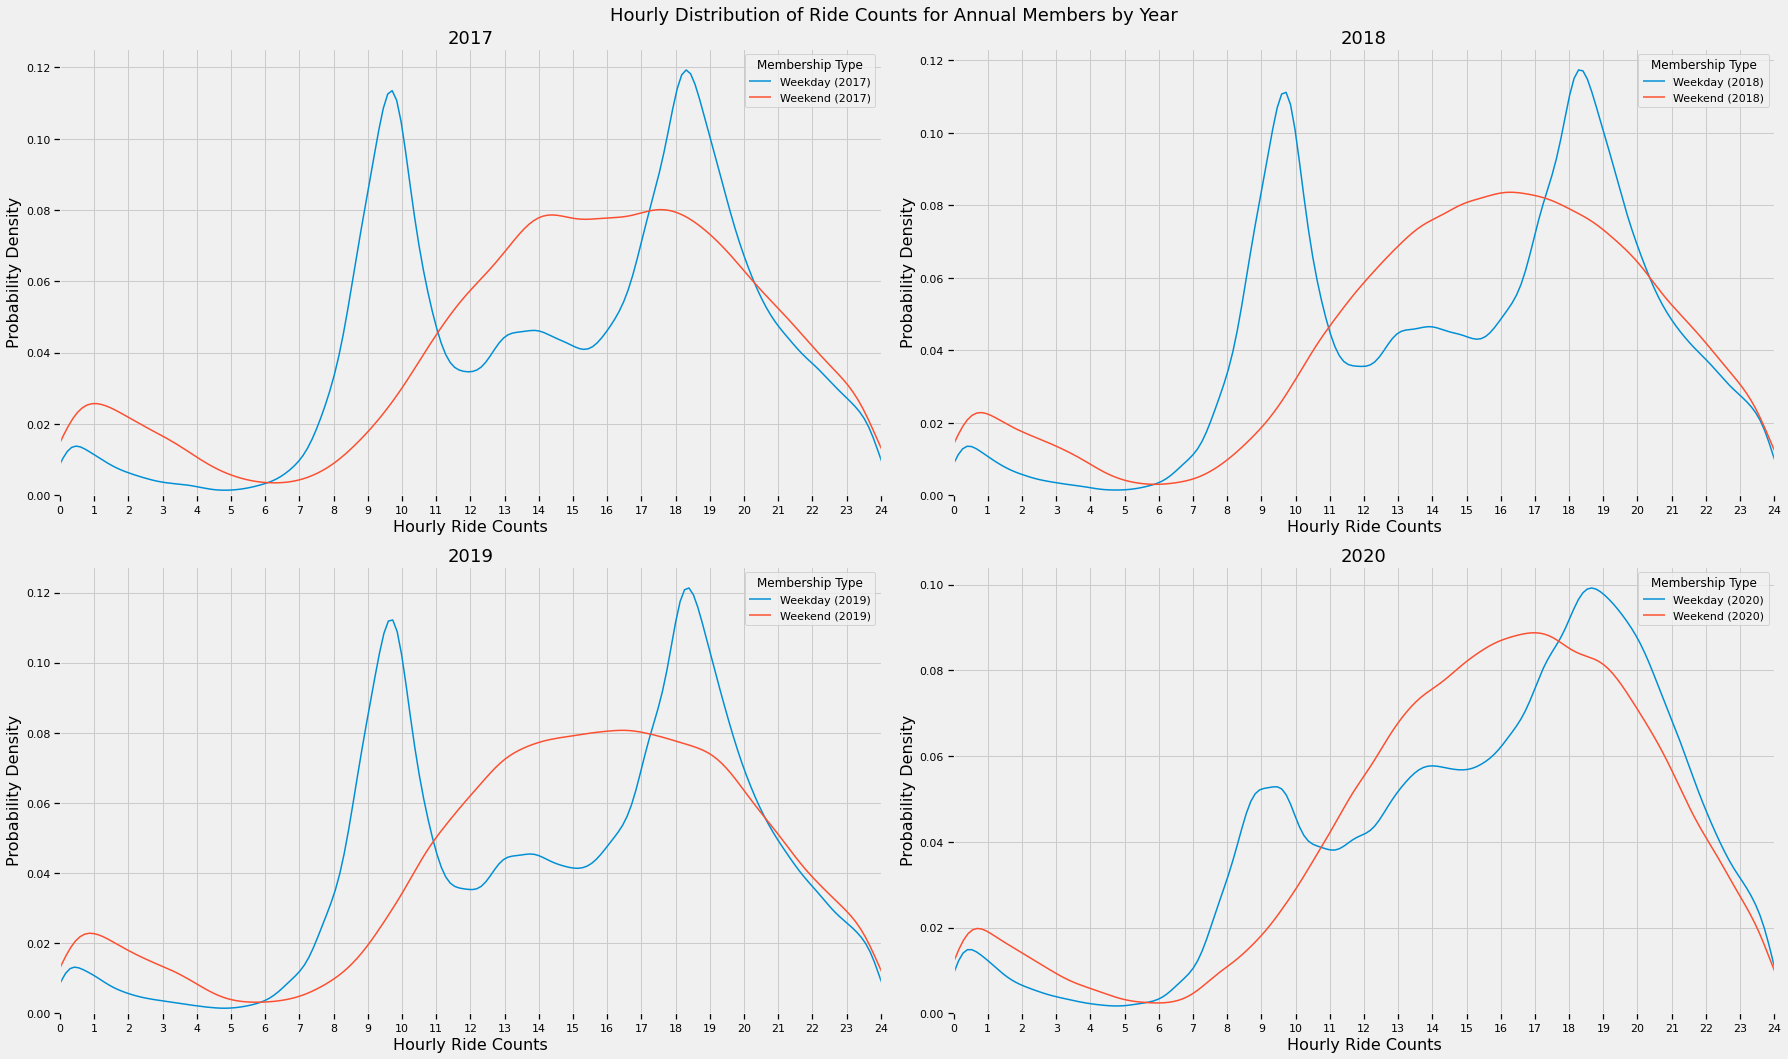

In [64]:
fig,axm = plt.subplots(2,2,figsize = (25,15))

user_type_str = 'annual'
lst_years = [2017,2018,2019,2020]


for indx in range(len(lst_years)):
    plt.subplot(2,2,indx+1)
    plt.xlim(0,24)
    #map data
    ax = sns.distplot(df_trips_data[(df_trips_data['user_type'] == user_type_str +' member')
                           & (df_trips_data['start_time'].dt.year == lst_years[indx])
                             & (df_trips_data['start_time'].dt.weekday <6)]['hour'], 
             label = "Weekday (" +str(lst_years[indx])+")", hist = False)
    ax = sns.distplot(df_trips_data[(df_trips_data['user_type'] == user_type_str +' member')
                           & (df_trips_data['start_time'].dt.year == lst_years[indx])
                             & (df_trips_data['start_time'].dt.weekday >=6)]['hour'], 
             label = "Weekend (" +str(lst_years[indx])+")", hist = False)    
    ax.set_title(str(lst_years[indx]),fontsize = 18)
    ax.set_xlabel("Hourly Ride Counts", fontsize = 16)
    ax.set_ylabel("Probability Density", fontsize = 16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.legend(title='Membership Type')
                           

#formate titles
fig.suptitle("Hourly Distribution of Ride Counts for Annual Members by Year",fontsize = 18)
fig.tight_layout()
plt.show()

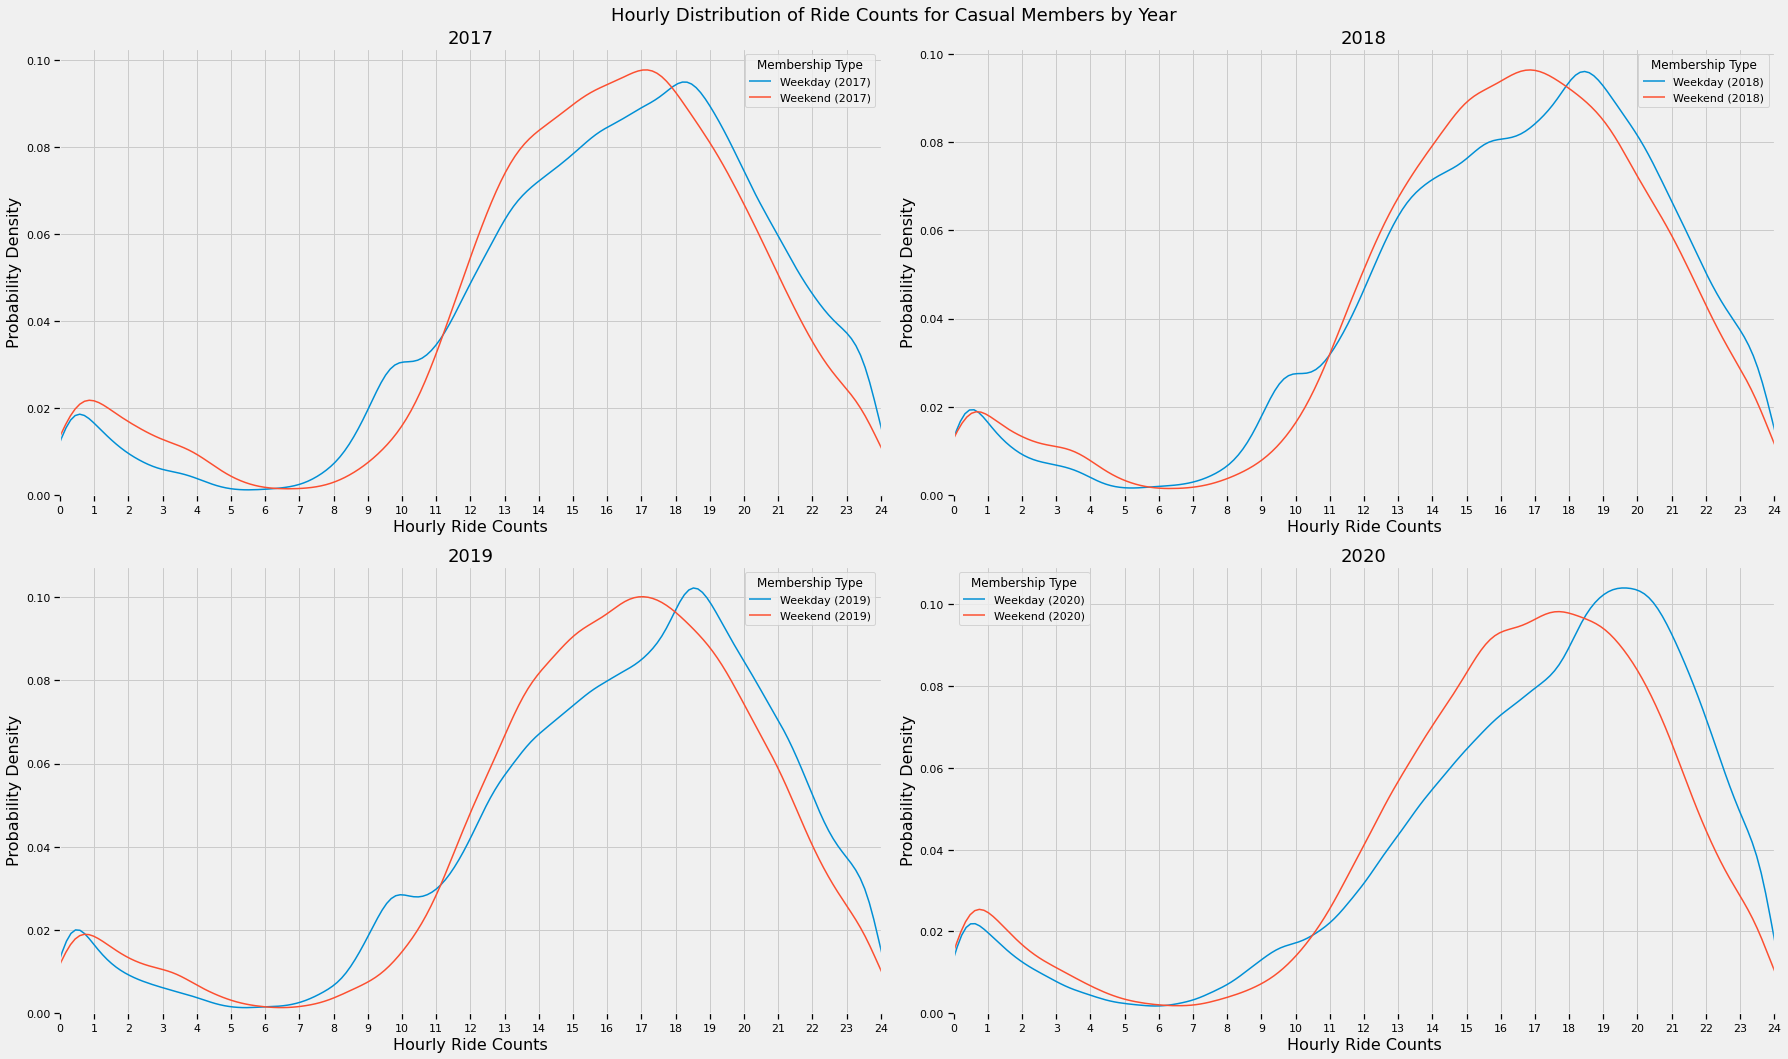

In [63]:
fig,axm = plt.subplots(2,2,figsize = (25,15))

user_type_str = 'casual'
lst_years = [2017,2018,2019,2020]


for indx in range(len(lst_years)):
    plt.subplot(2,2,indx+1)
    plt.xlim(0,24)
    #map data
    ax = sns.distplot(df_trips_data[(df_trips_data['user_type'] == user_type_str +' member')
                           & (df_trips_data['start_time'].dt.year == lst_years[indx])
                             & (df_trips_data['start_time'].dt.weekday <6)]['hour'], 
             label = "Weekday (" +str(lst_years[indx])+")", hist = False)
    ax = sns.distplot(df_trips_data[(df_trips_data['user_type'] == user_type_str +' member')
                           & (df_trips_data['start_time'].dt.year == lst_years[indx])
                             & (df_trips_data['start_time'].dt.weekday >=6)]['hour'], 
             label = "Weekend (" +str(lst_years[indx])+")", hist = False)    
    ax.set_title(str(lst_years[indx]),fontsize = 18)
    ax.set_xlabel("Hourly Ride Counts", fontsize = 16)
    ax.set_ylabel("Probability Density", fontsize = 16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.legend(title='Membership Type')
                           

#formate titles
fig.suptitle("Hourly Distribution of Ride Counts for Casual Members by Year",fontsize = 18)
fig.tight_layout()
plt.show()

### Differences in Duration of each member type

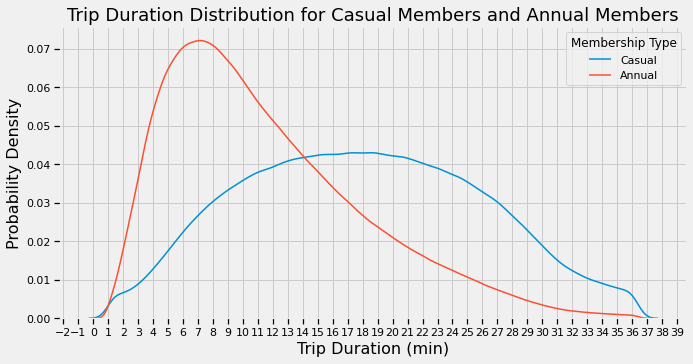

In [25]:

fig1 = plt.figure(figsize=(10,5))
ax2 = fig1.subplots()
ax2.set_xlim(0,36)

#map data
sns.distplot(df_trips_data[df_trips_data['user_type'] == 'casual member']['trip_duration']/60, label = "Casual",ax = ax2, hist = False)
sns.distplot(df_trips_data[df_trips_data['user_type'] == 'annual member']['trip_duration']/60, label = "Annual",ax = ax2, hist = False)

#formate titles
ax2.set_title("Trip Duration Distribution for Casual Members and Annual Members",fontsize = 18)
ax2.set_xlabel("Trip Duration (min)", fontsize = 16)
ax2.set_ylabel("Probability Density", fontsize = 16)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend(title='Membership Type')
plt.show()

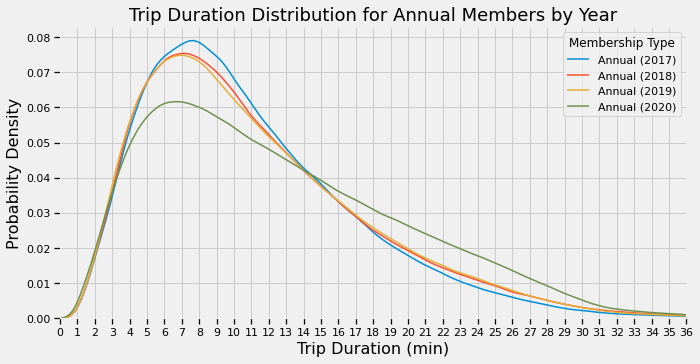

In [27]:
fig1 = plt.figure(figsize=(10,5))
ax2 = fig1.subplots()
ax2.set_xlim(0,36)

#map data
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'annual member')& (df_trips_data['start_time'].dt.year == 2017)]['trip_duration']/60, label = "Annual (2017)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'annual member')& (df_trips_data['start_time'].dt.year == 2018)]['trip_duration']/60, label = "Annual (2018)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'annual member')& (df_trips_data['start_time'].dt.year == 2019)]['trip_duration']/60, label = "Annual (2019)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'annual member')& (df_trips_data['start_time'].dt.year == 2020)]['trip_duration']/60, label = "Annual (2020)",ax = ax2, hist = False)
             
#formate titles
ax2.set_title("Trip Duration Distribution for Annual Members by Year",fontsize = 18)
ax2.set_xlabel("Trip Duration (min)", fontsize = 16)
ax2.set_ylabel("Probability Density", fontsize = 16)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend(title='Membership Type')
plt.show()

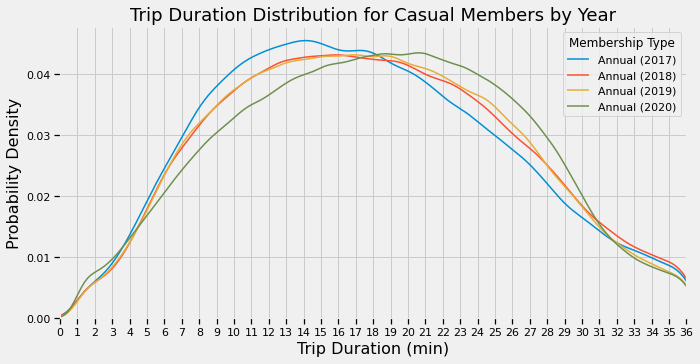

In [28]:
fig1 = plt.figure(figsize=(10,5))
ax2 = fig1.subplots()
ax2.set_xlim(0,36)

#map data
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'casual member')& (df_trips_data['start_time'].dt.year == 2017)]['trip_duration']/60, label = "Annual (2017)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'casual member')& (df_trips_data['start_time'].dt.year == 2018)]['trip_duration']/60, label = "Annual (2018)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'casual member')& (df_trips_data['start_time'].dt.year == 2019)]['trip_duration']/60, label = "Annual (2019)",ax = ax2, hist = False)
sns.distplot(df_trips_data[(df_trips_data['user_type'] == 'casual member')& (df_trips_data['start_time'].dt.year == 2020)]['trip_duration']/60, label = "Annual (2020)",ax = ax2, hist = False)
             
#formate titles
ax2.set_title("Trip Duration Distribution for Casual Members by Year",fontsize = 18)
ax2.set_xlabel("Trip Duration (min)", fontsize = 16)
ax2.set_ylabel("Probability Density", fontsize = 16)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.legend(title='Membership Type')
plt.show()

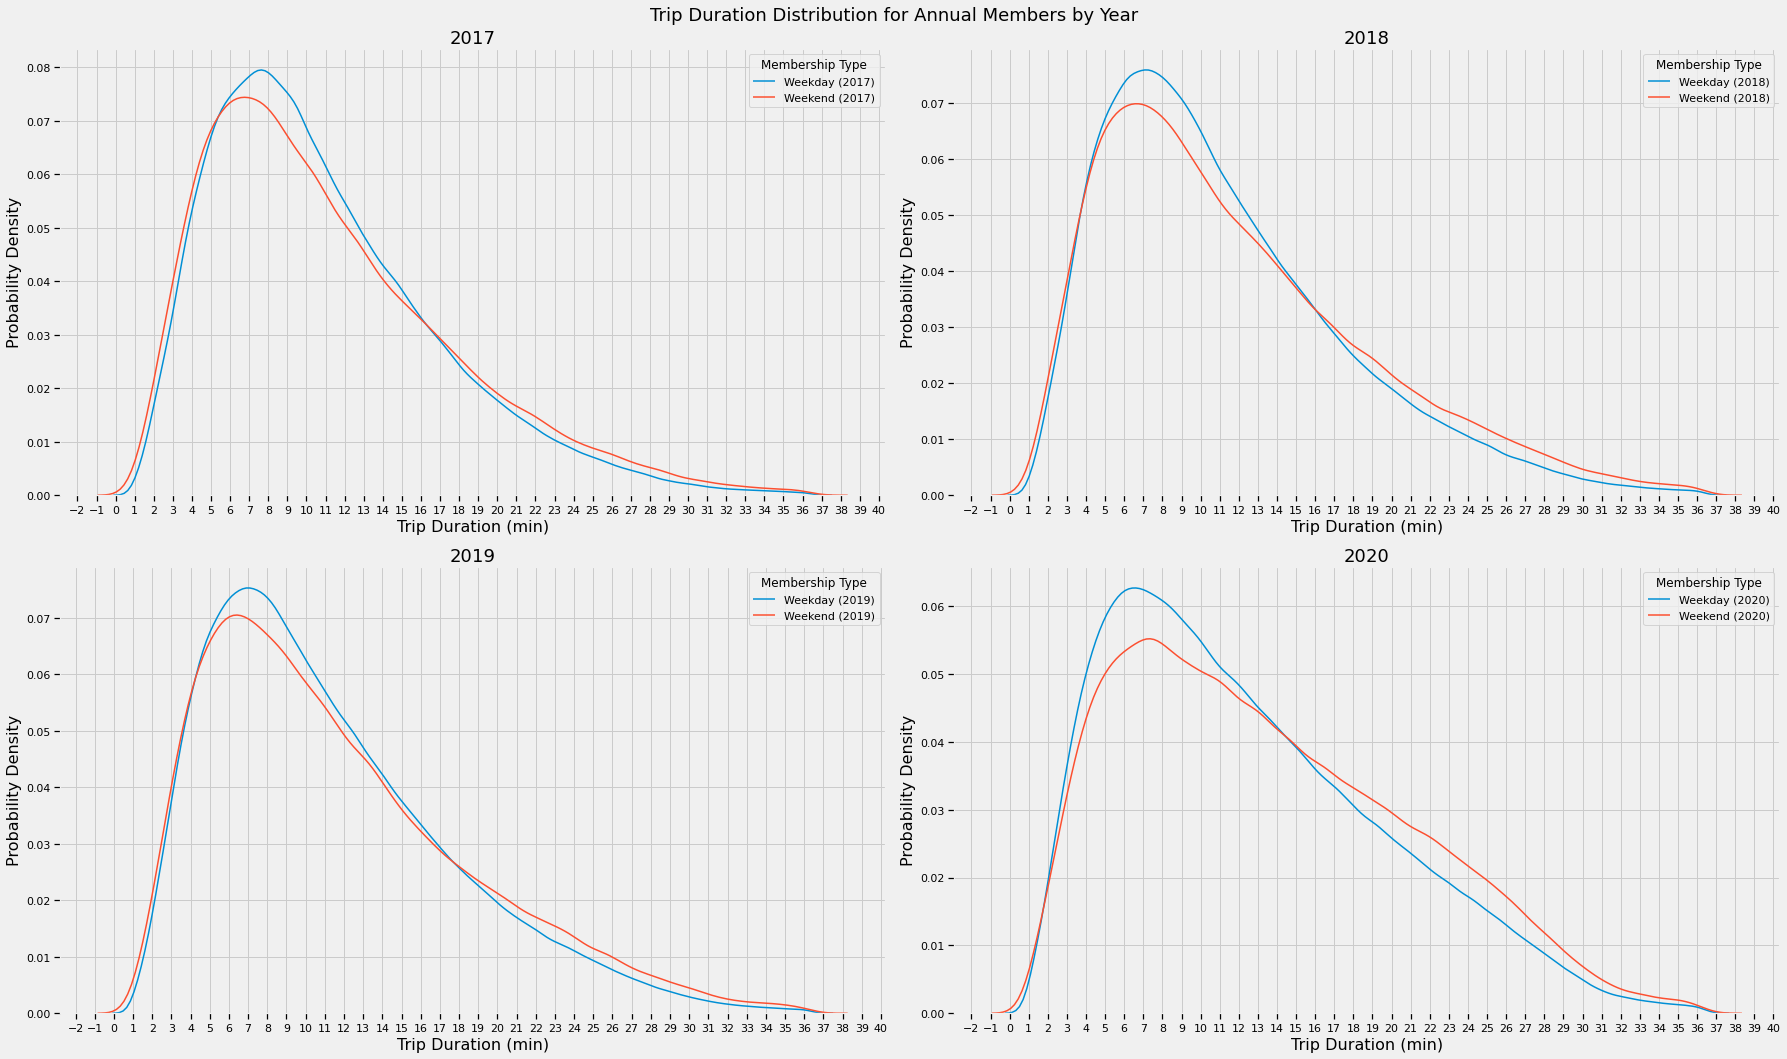

In [56]:
fig,axm = plt.subplots(2,2,figsize = (25,15))

user_type_str = 'annual'
lst_years = [2017,2018,2019,2020]


for indx in range(len(lst_years)):
    plt.subplot(2,2,indx+1)
    #plt.set_xlim(0,36)
    #map data
    ax = sns.distplot(df_trips_data[(df_trips_data['user_type'] == user_type_str +' member')
                           & (df_trips_data['start_time'].dt.year == lst_years[indx])
                             & (df_trips_data['start_time'].dt.weekday <6)]['trip_duration']/60, 
             label = "Weekday (" +str(lst_years[indx])+")", hist = False)
    ax = sns.distplot(df_trips_data[(df_trips_data['user_type'] == user_type_str +' member')
                           & (df_trips_data['start_time'].dt.year == lst_years[indx])
                             & (df_trips_data['start_time'].dt.weekday >=6)]['trip_duration']/60, 
             label = "Weekend (" +str(lst_years[indx])+")", hist = False)    
    ax.set_title(str(lst_years[indx]),fontsize = 18)
    ax.set_xlabel("Trip Duration (min)", fontsize = 16)
    ax.set_ylabel("Probability Density", fontsize = 16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.legend(title='Membership Type')
                           

#formate titles
fig.suptitle("Trip Duration Distribution for Annual Members by Year",fontsize = 18)
fig.tight_layout()
plt.show()

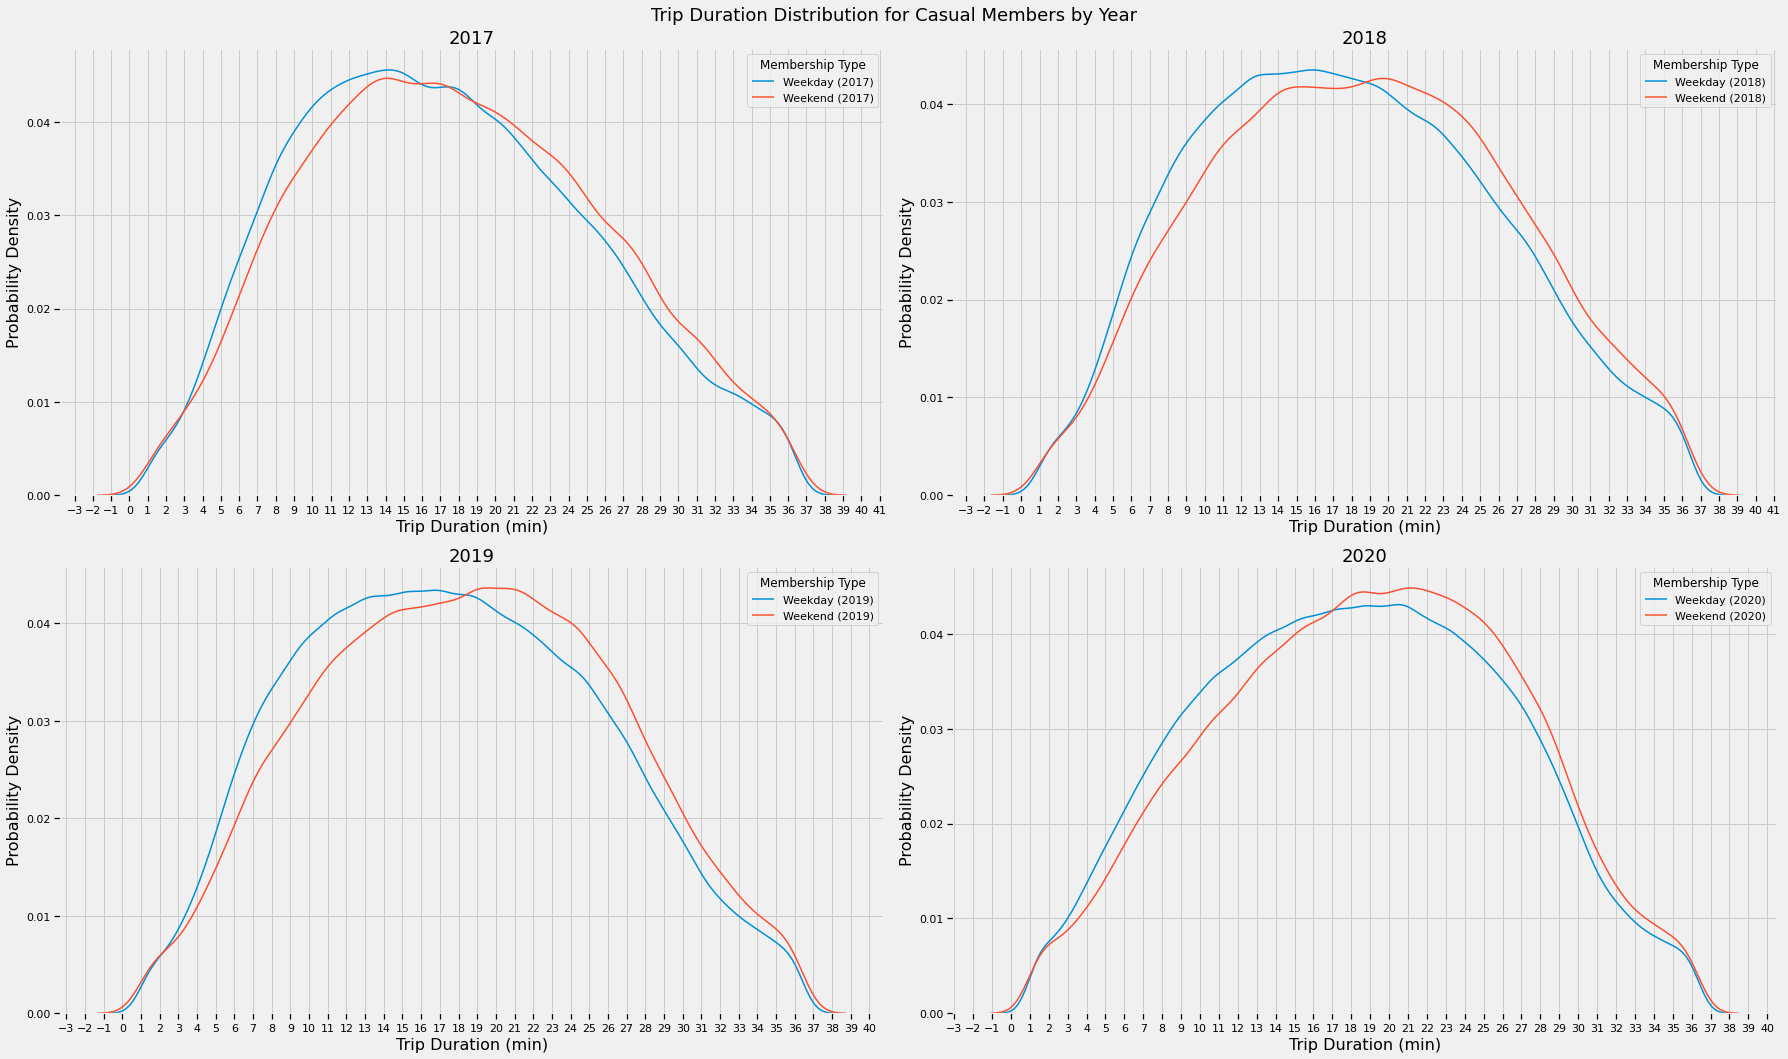

In [57]:
fig,axm = plt.subplots(2,2,figsize = (25,15))

user_type_str = 'casual'
lst_years = [2017,2018,2019,2020]


for indx in range(len(lst_years)):
    plt.subplot(2,2,indx+1)
    #plt.set_xlim(0,36)
    #map data
    ax = sns.distplot(df_trips_data[(df_trips_data['user_type'] == user_type_str +' member')
                           & (df_trips_data['start_time'].dt.year == lst_years[indx])
                             & (df_trips_data['start_time'].dt.weekday <6)]['trip_duration']/60, 
             label = "Weekday (" +str(lst_years[indx])+")", hist = False)
    ax = sns.distplot(df_trips_data[(df_trips_data['user_type'] == user_type_str +' member')
                           & (df_trips_data['start_time'].dt.year == lst_years[indx])
                             & (df_trips_data['start_time'].dt.weekday >=6)]['trip_duration']/60, 
             label = "Weekend (" +str(lst_years[indx])+")", hist = False)    
    ax.set_title(str(lst_years[indx]),fontsize = 18)
    ax.set_xlabel("Trip Duration (min)", fontsize = 16)
    ax.set_ylabel("Probability Density", fontsize = 16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.legend(title='Membership Type')
                           

#formate titles
fig.suptitle("Trip Duration Distribution for Casual Members by Year",fontsize = 18)
fig.tight_layout()
plt.show()

## 3.  Which neighbourhoods have seen the largest number of rides depart from bike stations located within their boundaries?

## 4. Which neighbourhoods have seen the largest number of rides end at bike stations located within their boundaries?

<ol>
    <li> Import a map of the neighbourhoods </li>
    <li> Determine which station is in which neighboorhood </li>
    <li> Count rides starting in a Neighbourhood </li>
    <li> Generate Heat map of Neighbourhoods and ride start and end locations </li>
</ol>

In [19]:
# Import the map of the Toronto neighborhood
neighbourhoods = gpd.read_file('toronto_neighbourhoods.shp')

# View GeoDataFrame
neighbourhoods.head()

FIELD_1   FIELD_2   FIELD_3  FIELD_4  FIELD_5  FIELD_6  \
0     2101  25886861  25926662    49885       94       94   
1     2102  25886820  25926663    49885      100      100   
2     2103  25886834  25926664    49885       97       97   
3     2104  25886593  25926665    49885       27       27   
4     2105  25886688  25926666    49885       31       31   

                        FIELD_7                       FIELD_8 FIELD_9  \
0                 Wychwood (94)                 Wychwood (94)    None   
1          Yonge-Eglinton (100)          Yonge-Eglinton (100)    None   
2           Yonge-St.Clair (97)           Yonge-St.Clair (97)    None   
3  York University Heights (27)  York University Heights (27)    None   
4       Yorkdale-Glen Park (31)       Yorkdale-Glen Park (31)    None   

  FIELD_10   FIELD_11   FIELD_12  FIELD_13      FIELD_14      FIELD_15  \
0     None -79.425515  43.676919  16491505  3.217960e+06   7515.779658   
1     None -79.403590  43.704689  16491521  3.160334e+06   7872.021074   
2     None -79.397871  43.687859  16491537  2.222464e+06   8130.411276   
3     None -79.488883  43.765736  16491553  2.541821e+07  25632.335242   
4     None -79.457108  43.714672  16491569  1.156669e+07  13953.408098   

                                            geometry  
0  POLYGON ((-79.43592 43.68015, -79.43492 43.680...  
1  POLYGON ((-79.41096 43.70408, -79.40962 43.704...  
2  POLYGON ((-79.39119 43.68108, -79.39141 43.680...  
3  POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
4  POLYGON ((-79.43969 43.70561, -79.44011 43.705...

In [20]:
neighbourhoods['FIELD_8']= neighbourhoods['FIELD_8'].str.split('(', expand = True)
neighbourhoods = neighbourhoods[['geometry', 'FIELD_8']]
neighbourhoods.rename(columns ={'FIELD_8':'neighbourhood'}, inplace = True)
print(neighbourhoods.crs)
neighbourhoods.head()

epsg:4326


geometry             neighbourhood
0  POLYGON ((-79.43592 43.68015, -79.43492 43.680...                 Wychwood 
1  POLYGON ((-79.41096 43.70408, -79.40962 43.704...           Yonge-Eglinton 
2  POLYGON ((-79.39119 43.68108, -79.39141 43.680...           Yonge-St.Clair 
3  POLYGON ((-79.50529 43.75987, -79.50488 43.759...  York University Heights 
4  POLYGON ((-79.43969 43.70561, -79.44011 43.705...       Yorkdale-Glen Park

The bikeshare_stations GeoDataFrame does not contain crs information because we contructed it ourselves from (lat,lon) coordinates. However, we know from publicbikesystem.net that the station locations have the same crs as neighbourhoods.

So, let's set the crs of bikeshare_stations_gdf (EPSG:4326).

In [21]:
#aim to analyse the change during each year

#use geopandas to match neighboorhoods to stations

def find_neighboorhood(row):
    for x in range(neighbourhoods.shape[0]):
        if row.within(neighbourhoods.loc[x,'geometry']):
            return neighbourhoods.loc[x,'neighbourhood']
        
def riders_per_neighbourhood_year(stations_info,df_trips,year,df_neighbourhoods):
    df = stations_info.copy()
    df_output = df_neighbourhoods.copy()
    # calc number of trips starting and ending at each stations based on station id
    start = df_trips[df_trips['start_time'].dt.year == year]['start_station_id'].value_counts()
    end = df_trips[df_trips['start_time'].dt.year == year]['end_station_id'].value_counts()
    
    #merge start trip value counts and rename column
    df = pd.merge(df,start, left_on = 'station_id', right_index = True, how = 'inner')
    df.rename(columns = {'start_station_id':'start_ride_count'}, inplace = True)
    
    #merge start trip value counts and rename column
    df = pd.merge(df,end, left_on = 'station_id', right_index = True, how = 'inner')
    df.rename(columns = {'end_station_id':'end_ride_count'}, inplace = True)
    
    #assign to neighbourhoods
    df_output['rides_started'] = df_output.apply(lambda row: df['start_ride_count'][df.within(row.geometry)].sum(), axis = 1)
    df_output['rides_ended'] = df_output.apply(lambda row: df['end_ride_count'][df.within(row.geometry)].sum(), axis = 1)
    #use focus on neighbourhoods with rides starting and ending within the neighbourhoods
    
    return df_output[(df_output['rides_started']>0) | (df_output['rides_ended']>0)]




#######################################################################################

#create a stations dataframe with station name, id and neighbourhood
df_stations = pd.read_csv('bikeshare_stations.csv')
df_stations.columns = [s.replace(' ','_').lower() for s in df_stations.columns ]
df_stations = gpd.GeoDataFrame(df_stations,geometry=gpd.points_from_xy(df_stations['lon'],df_stations['lat']))
df_stations.crs = {'init': 'epsg:4326'}

#assign neighbourhoods
#df_stations['neighbourhood'] = df_stations.apply(lambda row: find_neighboorhood(row.geometry), axis=1 )

#calc for 2017
df_neighbourhood_traffic_2017 = riders_per_neighbourhood_year(df_stations,df_trips_data,2017,neighbourhoods)
df_neighbourhood_traffic_2018 = riders_per_neighbourhood_year(df_stations,df_trips_data,2018,neighbourhoods)
df_neighbourhood_traffic_2019 = riders_per_neighbourhood_year(df_stations,df_trips_data,2019,neighbourhoods)
df_neighbourhood_traffic_2020 = riders_per_neighbourhood_year(df_stations,df_trips_data,2020,neighbourhoods)


df_neighbourhood_traffic_2017.head(100)
print('In 2017 the neighbourhood with the most trips starting within the neighbourhood was:', df_neighbourhood_traffic_2017.sort_values('rides_started',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('In 2017 the neighbourhood with the most trips end within the neighbourhood was:', df_neighbourhood_traffic_2017.sort_values('rides_ended',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('\n')
print('In 2018 the neighbourhood with the most trips starting within the neighbourhood was:', df_neighbourhood_traffic_2018.sort_values('rides_started',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('In 2018 the neighbourhood with the most trips end within the neighbourhood was:', df_neighbourhood_traffic_2018.sort_values('rides_ended',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('\n')
print('In 2019 the neighbourhood with the most trips starting within the neighbourhood was:', df_neighbourhood_traffic_2019.sort_values('rides_started',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('In 2019 the neighbourhood with the most trips end within the neighbourhood was:', df_neighbourhood_traffic_2019.sort_values('rides_ended',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('\n')
print('In 2020 the neighbourhood with the most trips starting within the neighbourhood was:', df_neighbourhood_traffic_2020.sort_values('rides_started',ascending = False, axis =0)['neighbourhood'].tolist()[0])
print('In 2020 the neighbourhood with the most trips end within the neighbourhood was:', df_neighbourhood_traffic_2020.sort_values('rides_ended',ascending = False, axis =0)['neighbourhood'].tolist()[0])


In 2017 the neighbourhood with the most trips starting within the neighbourhood was: Waterfront Communities-The Island 
In 2017 the neighbourhood with the most trips end within the neighbourhood was: Waterfront Communities-The Island 


In 2018 the neighbourhood with the most trips starting within the neighbourhood was: Waterfront Communities-The Island 
In 2018 the neighbourhood with the most trips end within the neighbourhood was: Waterfront Communities-The Island 


In 2019 the neighbourhood with the most trips starting within the neighbourhood was: Waterfront Communities-The Island 
In 2019 the neighbourhood with the most trips end within the neighbourhood was: Waterfront Communities-The Island 


In 2020 the neighbourhood with the most trips starting within the neighbourhood was: Waterfront Communities-The Island 
In 2020 the neighbourhood with the most trips end within the neighbourhood was: Waterfront Communities-The Island 


#### Analysis
The trend seems be consitent though out the years!
- Check which neighbourhood had the most stations
- Treat the data set as a single data set. 

In [75]:
def station_in_neighbourhood (row):
    cntr = 0
    for x in df_stations.geometry:
        if x.within(row.geometry):
            cntr +=1
    return cntr
            
neighbourhoods['stations'] = neighbourhoods.apply(lambda row: station_in_neighbourhood(row), axis=1 )
neighbourhoods.sort_values(by = ['stations'], inplace = True, ascending = False)

neighbourhoods['station_density'] = neighbourhoods['stations']/neighbourhoods.geometry.area

# View GeoDataFrame
neighbourhoods.head(10)

geometry  \
61   POLYGON ((-79.37697 43.64688, -79.37576 43.647...   
80   POLYGON ((-79.38752 43.65067, -79.38663 43.650...   
97   POLYGON ((-79.37672 43.66242, -79.37658 43.662...   
26   POLYGON ((-79.42778 43.62979, -79.42781 43.629...   
136  POLYGON ((-79.40401 43.64719, -79.40419 43.647...   
49   POLYGON ((-79.32868 43.64745, -79.32867 43.647...   
18   POLYGON ((-79.35174 43.65557, -79.35208 43.655...   
77   POLYGON ((-79.39414 43.66872, -79.39588 43.668...   
106  POLYGON ((-79.41842 43.66358, -79.41887 43.663...   
59   POLYGON ((-79.40772 43.65648, -79.40847 43.658...   

                            neighbourhood  stations  station_density  
61     Waterfront Communities-The Island         60     40082.256532  
80                   Bay Street Corridor         47    232730.981815  
97                 Church-Yonge Corridor         32    210090.029558  
26                               Niagara         31     85713.809383  
136                 Kensington-Chinatown         26    151796.641042  
49                       South Riverdale         22     17978.615195  
18                             Moss Park         21    133149.733503  
77                                 Annex         21     67410.048564  
106  Dovercourt-Wallace Emerson-Junction         20     48083.657833  
59                            University         19    121124.035862

<b> Considering that Waterfront Communities - The Island has the most stations is could be expected that the greatest number of rides begin and end in the neighbourhood! </b>

In [68]:
df_neighbourhoods = neighbourhoods.copy()
# calc number of trips starting and ending at each stations based on station id
start = df_trips_data['start_station_id'].value_counts()
end = df_trips_data['end_station_id'].value_counts()
    
#merge start trip value counts and rename column
df_stations = pd.merge(df_stations,start, left_on = 'station_id', right_index = True, how = 'inner')
df_stations.rename(columns = {'start_station_id':'start_ride_count'}, inplace = True)
    
#merge start trip value counts and rename column
df_stations = pd.merge(df_stations,end, left_on = 'station_id', right_index = True, how = 'inner')
df_stations.rename(columns = {'end_station_id':'end_ride_count'}, inplace = True)

df_neighbourhoods['rides_started_perc'] = np.nan
df_neighbourhoods['rides_ended_perc'] = np.nan
df_neighbourhoods['rides_started_count'] = np.nan
df_neighbourhoods['rides_ended_count'] = np.nan


#assign to neighbourhoods
df_neighbourhoods['rides_started_count'] = df_neighbourhoods.apply(lambda row: df_stations['start_ride_count'][df_stations.within(row.geometry)].sum(), axis = 1)
df_neighbourhoods['rides_ended_count'] = df_neighbourhoods.apply(lambda row: df_stations['end_ride_count'][df_stations.within(row.geometry)].sum(), axis = 1)
df_neighbourhoods['rides_started_perc'] = df_neighbourhoods.apply(lambda row: df_stations['start_ride_count'][df_stations.within(row.geometry)].sum(), axis = 1)/df_trips_data.shape[0]*100
df_neighbourhoods['rides_ended_perc'] = df_neighbourhoods.apply(lambda row: df_stations['end_ride_count'][df_stations.within(row.geometry)].sum(), axis = 1)/df_trips_data.shape[0]*100
    #use focus on neighbourhoods with rides starting and ending within the neighbourhoods

#df_neighbourhoods_map = [df_neighbourhoods['rides_started_perc']>0]
df_neighbourhoods_map = df_neighbourhoods[(df_neighbourhoods['rides_started_perc']>0) | (df_neighbourhoods['rides_ended_perc']>0)]


### Plot the values for each neighbourhood

In [69]:
# Create a base map -79.43592 43.68015
map_3 = folium.Map(location=[43.68015, -79.43592], 
                     tiles='cartodbpositron',
                     zoom_start=11)

# Add station to the map
for idx, row in df_stations.to_crs(epsg=4326).iterrows():
    folium.CircleMarker([row.geometry.y, row.geometry.x],
                         radius=1,
                         color='blue',fill=True,fill_color='#3186cc',
                         fill_opacity=0,parse_html=False).add_to(map_3)

# Add a choropleth map to the base map
Choropleth(geo_data=df_neighbourhoods_map.__geo_interface__, 
           columns=['neighbourhood', 'rides_started_perc'],
           data=df_neighbourhoods_map,
           key_on='feature.properties.neighbourhood',
           fill_color='YlOrRd', 
           legend_name='Percentage of Rides Starting'
          ).add_to(map_3)

map_3

In [70]:
# Create a base map 
map_3 = folium.Map(location=[43.68015, -79.43592], 
                     tiles='cartodbpositron',
                     zoom_start=11)

# Add station to the map
for idx, row in df_stations.to_crs(epsg=4326).iterrows():
    folium.CircleMarker([row.geometry.y, row.geometry.x],
                         radius=1,
                         color='blue',fill=True,fill_color='#3186cc',
                         fill_opacity=0,parse_html=False).add_to(map_3)

# Add a choropleth map to the base map
Choropleth(geo_data=df_neighbourhoods_map.__geo_interface__, 
           columns=['neighbourhood', 'rides_ended_perc'],
           data=df_neighbourhoods_map,
           key_on='feature.properties.neighbourhood',
           fill_color='YlOrRd', 
           legend_name='Percentage of Rides Ending'
          ).add_to(map_3)


map_3

# 5. How popular is FREE RIDE WEDNESDAYS?

The popularity of FREE RIDE WEDNESDAYS can be assessed by looking at the change the ride count over the course of the week. If it is popular, we should see more rides being taken on Wednesdays. 

In [76]:
#convert the day of week numeric value into string
df_usage_perd_bymem['dayofweek_str']=df_usage_perd_bymem['dayofweek'].replace({0: 'MON', 1: 'TUE', 2:'WED',3:'THU',4:'FRI',5:'SAT',6:'SUN'})
df_usage_perd_bymem.head()

trip_count member  year  dayofyear  day  month  \
start_time                                                                  
2017-01-01 00:00:00-05:00         482  total  2017          1    1      1   
2017-01-02 00:00:00-05:00         826  total  2017          2    2      1   
2017-01-03 00:00:00-05:00         871  total  2017          3    3      1   
2017-01-04 00:00:00-05:00        1395  total  2017          4    4      1   
2017-01-05 00:00:00-05:00        1210  total  2017          5    5      1   

                           dayofweek isweek_day member_week_day dayofweek_str  
start_time                                                                     
2017-01-01 00:00:00-05:00          6    weekend  total, weekend           SUN  
2017-01-02 00:00:00-05:00          0    weekday  total, weekday           MON  
2017-01-03 00:00:00-05:00          1    weekday  total, weekday           TUE  
2017-01-04 00:00:00-05:00          2    weekday  total, weekday           WED  
2017-01-05 00:00:00-05:00          3    weekday  total, weekday           THU

The plot below shows the average daily rides by day of week and year. The average daily ride count on wednesdays are the highest for the years 2017, 2018 and 2019, but the frequency is only slightly greater than other weekdays. There is also a slight increase in the average daily ride count on wednesdays for 2020, but it is not the highest like in the previous years. There is significantly more rides taken on the weekends and fridays are also slightly more popular than wednesdays. 

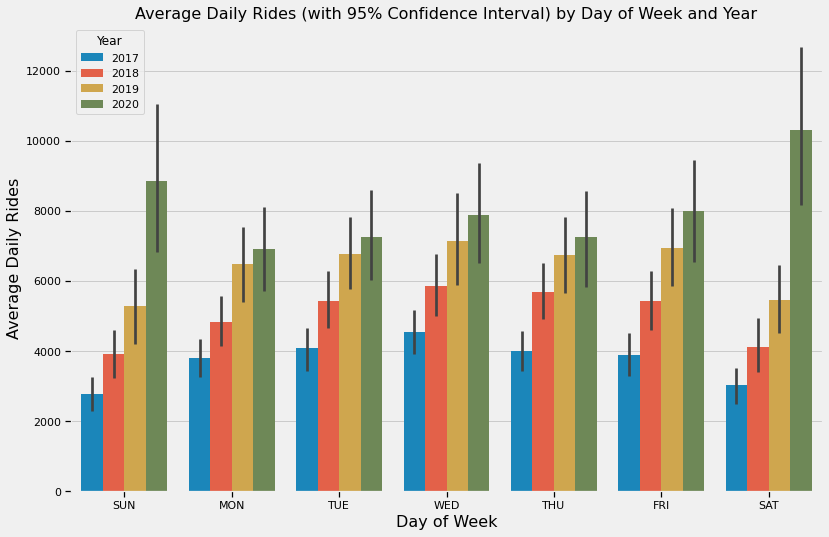

In [77]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x=df_usage_perd_bymem[df_usage_perd_bymem['member']=='total']['dayofweek_str'],
               y=df_usage_perd_bymem[df_usage_perd_bymem['member']=='total']['trip_count'],
               hue=df_usage_perd_bymem[df_usage_perd_bymem['member']=='total']['year'])
ax.axes.set_title("Average Daily Rides (with 95% Confidence Interval) by Day of Week and Year",
                      fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
ax.set_xlabel("Day of Week",
                  fontsize=16)
ax.legend(title='Year')
plt.show()

The plot below shows the average daily rides by day of week and membership type. If the FREE WEDNESDAY promotion was popular, we would anticipate that it would be popular among the casual members, but not necessarily the annual members.  The annual members already have unlimited 30 minute bike rides for the year, so they do not need to take advantage of the FREE RIDE WEDNESDAY. 

Interesting to note, wednesday tends to be the most popular day of all the weekdays for both the annual and casual members. The difference compared to other weekdays, however, is only slight. The wednesday peak for annual members is not due to the promotion. The graph tells us that we should be looking at just the casual members to assess the popularity of FREE RIDE WEDNESDAYS because including the annual members may confound our results. 

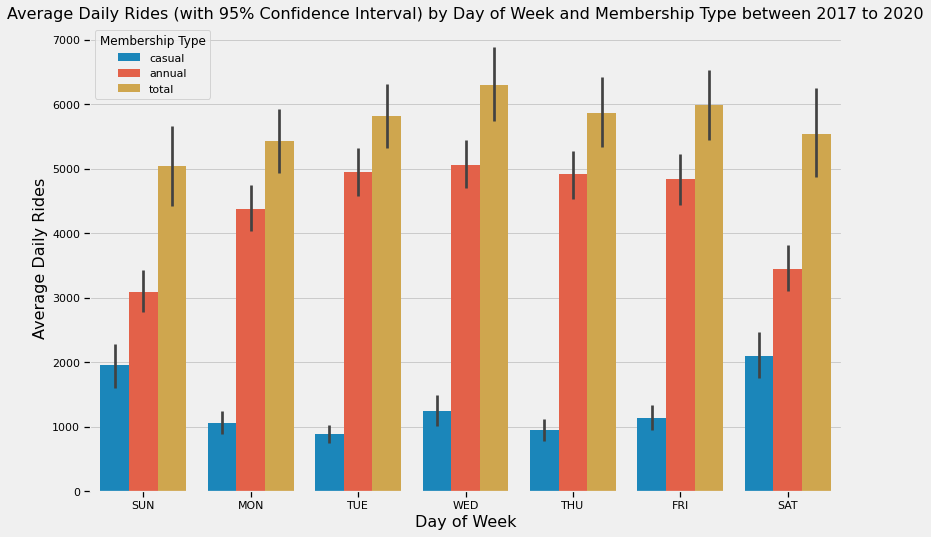

In [78]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x=df_usage_perd_bymem['dayofweek_str'],
               y=df_usage_perd_bymem['trip_count'], 
               hue=df_usage_perd_bymem['member'], hue_order=['casual','annual','total'])
ax.axes.set_title("Average Daily Rides (with 95% Confidence Interval) by Day of Week and Membership Type between 2017 to 2020",
                      fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
ax.set_xlabel("Day of Week",
                  fontsize=16)
ax.legend(title='Membership Type')
plt.show()

Looking at the average ride count for casual riders by day of week and year, we can see that there is a slight increase in the average ride count on wednesdays compared to other week days for 2017, 2018 and 2019. For 2020, there is a slight increase in the average as well but Friday is the most popular of all weekdays. 

This plot seems to suggest that FREE RIDE WEDNESDAY is not that popular.  

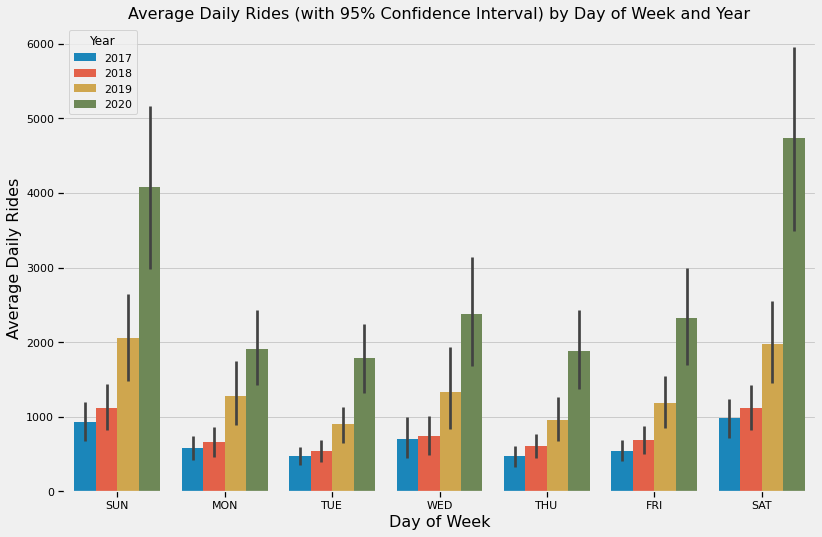

In [79]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x=df_usage_perd_bymem[df_usage_perd_bymem['member']=='casual']['dayofweek_str'],
               y=df_usage_perd_bymem[df_usage_perd_bymem['member']=='casual']['trip_count'],
               hue=df_usage_perd_bymem[df_usage_perd_bymem['member']=='casual']['year'])
ax.axes.set_title("Average Daily Rides (with 95% Confidence Interval) by Day of Week and Year",
                      fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
ax.set_xlabel("Day of Week",
                  fontsize=16)
ax.legend(title='Year')
plt.show()

The above analysis was conducted assuming that FREE RIDE WEDNESDAYS were available for bike riders every wednesday. However, in digging into the timeframe for which this promotion was offered, this assumption may have been erroneous. 

For example, this <a href="https://bikesharetoronto.com/news/free-ride-wednesdays-are-back-and-e-bikes-are-joining-the-fleet/">article</a> would suggest that this promotion was only offered in the month of September for 2020. This <a href="https://bikesharetoronto.com/news/free-ride-wednesdays-is-back/">article</a> would suggest that the promotion was offered in August for 2019. In <a href="https://bikesharetoronto.com/news/free-ride-wednesday-2018/">2018</a>, it was offered in the month of June. In <a href="https://bikesharetoronto.com/news/mayor-john-tory-bike-share-toronto-roll-free-ride-wednesdays-july/">2017</a>, it was offered in the month of July. 

We will narrow our dataset to these specific months for which we know FREE RIDE WEDNESDAY promotion was offered and re-conduct the analysis. 

In [80]:
#subset the dataframe to only include time period for which FREE RIDE WEDNESDAY promotion was offered
subset2020=df_usage_perd_bymem[(df_usage_perd_bymem.index.year==2020)&(df_usage_perd_bymem.index.month==9)]
subset2019=df_usage_perd_bymem[(df_usage_perd_bymem.index.year==2019)&(df_usage_perd_bymem.index.month==8)]
subset2018=df_usage_perd_bymem[(df_usage_perd_bymem.index.year==2018)&(df_usage_perd_bymem.index.month==6)]
subset2017=df_usage_perd_bymem[(df_usage_perd_bymem.index.year==2017)&(df_usage_perd_bymem.index.month==7)]

#Combine the dataset
freeride=pd.concat([subset2020,subset2019,subset2018,subset2017])
freeride.head()

trip_count member  year  dayofyear  day  month  \
start_time                                                                  
2020-09-01 00:00:00-04:00       13924  total  2020        245    1      9   
2020-09-02 00:00:00-04:00       14803  total  2020        246    2      9   
2020-09-03 00:00:00-04:00       14673  total  2020        247    3      9   
2020-09-04 00:00:00-04:00       15575  total  2020        248    4      9   
2020-09-05 00:00:00-04:00       18436  total  2020        249    5      9   

                           dayofweek isweek_day member_week_day dayofweek_str  
start_time                                                                     
2020-09-01 00:00:00-04:00          1    weekday  total, weekday           TUE  
2020-09-02 00:00:00-04:00          2    weekday  total, weekday           WED  
2020-09-03 00:00:00-04:00          3    weekday  total, weekday           THU  
2020-09-04 00:00:00-04:00          4    weekday  total, weekday           FRI  
2020-09-05 00:00:00-04:00          5    weekday  total, weekday           SAT

The above graph demonstrates that FREE RIDE WEDNESDAY promotions do significantly increase the number of rides taken on Wednesdays. For 2017 - 2019, the frequency of rides taken more than doubles compared to other weekdays. For 2020, the frequency does not quite double, but there is significantly more rides taken on the Wednesdays when the promotion is available. 

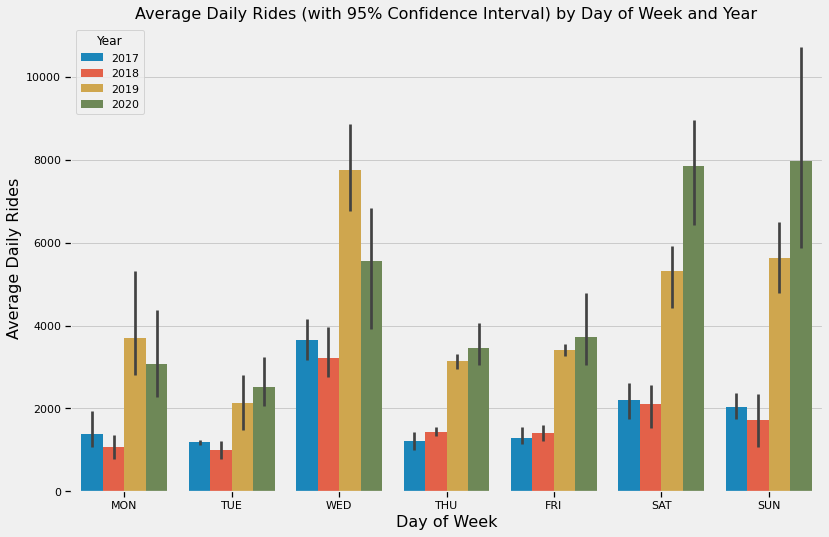

In [81]:
plt.figure(figsize=(12,8))
ax=sns.barplot(data= freeride[freeride['member']=='casual'], x='dayofweek_str',y='trip_count',hue='year',
               order=['MON','TUE','WED','THU','FRI','SAT','SUN'])
ax.axes.set_title("Average Daily Rides (with 95% Confidence Interval) by Day of Week and Year",
                      fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
ax.set_xlabel("Day of Week",
                  fontsize=16)
ax.legend(title='Year')
plt.show()

In [82]:
#subset for dates when FREE RIDE WEDNESDAY promotion was not available
subset2020=df_usage_perd_bymem[df_usage_perd_bymem.index.year==2020]
subset2020=subset2020[~(subset2020.index.month==9)]
subset2019=df_usage_perd_bymem[df_usage_perd_bymem.index.year==2019]
subset2019=subset2019[~(subset2019.index.month==8)]
subset2018=df_usage_perd_bymem[df_usage_perd_bymem.index.year==2018]
subset2018=subset2018[~(subset2018.index.month==6)]
subset2017=df_usage_perd_bymem[df_usage_perd_bymem.index.year==2017]
subset2017=subset2017[~(subset2017.index.month==7)]

#Combine the dataset
nofreeride=pd.concat([subset2020,subset2019,subset2018,subset2017])
nofreeride['promo']='no promo'
freeride['promo']='promo'
all_data = pd.concat([nofreeride,freeride])
all_data=all_data[all_data['member']=='casual']

The graph below compares the average daily ride count for days with the FREE RIDE WEDNESDAY promotion and days without the promotion. It is evident that the promotion does significantly increase the number of rides taken on Wednesdays. When the promotion is available, the trip count is 5x greater compared to when the promotion is not available. When the promotion is available, the ride frequency on Wednesdays exceeds that on the weekends. 

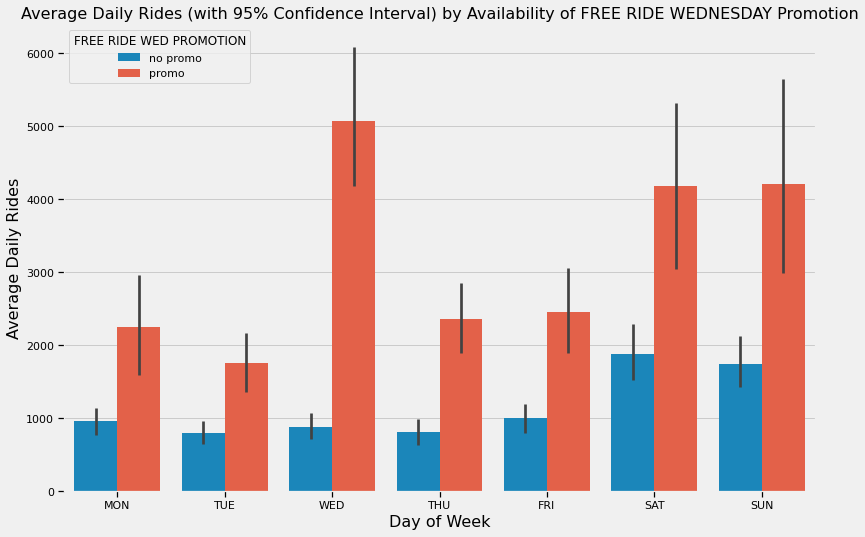

In [83]:
plt.figure(figsize=(12,8))
ax=sns.barplot(data= all_data, x='dayofweek_str',y='trip_count',hue='promo',
               order=['MON','TUE','WED','THU','FRI','SAT','SUN'])
ax.axes.set_title("Average Daily Rides (with 95% Confidence Interval) by Availability of FREE RIDE WEDNESDAY Promotion",
                      fontsize=16)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylabel("Average Daily Rides",
                  fontsize=16)
ax.set_xlabel("Day of Week",
                  fontsize=16)
ax.legend(title='FREE RIDE WED PROMOTION')
plt.show()

In [84]:
#the average daily rides when the FREE RIDE WEDNESDAY promotion is available
x=all_data[(all_data['dayofweek_str']=='WED')&(all_data['promo']=='promo')]['trip_count'].agg('mean')
print("The average daily ride count for Wednesdays when FREE RIDE FRIDAY promotion is available:", round(x))
#the average daily rides when the FREE RIDE WEDNESDAY promotion is not available
x=all_data[(all_data['dayofweek_str']=='WED')&(all_data['promo']=='no promo')]['trip_count'].agg('mean')
print("The average daily ride count for Wednesdays when FREE RIDE FRIDAY promotion is not  available:", round(x))

The average daily ride count for Wednesdays when FREE RIDE FRIDAY promotion is available: 5073
The average daily ride count for Wednesdays when FREE RIDE FRIDAY promotion is not  available: 885


# 6/7. How does the weather change the way people use the bike share system?What weather features are most influential (temperature,humidity,precipitation, etc.)?